This is a simple CNN for the classification of bat species based on echolocation calls

In [1]:
import librosa
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import io
import sqlite3
import os
from scipy.signal import butter, lfilter
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.activations import relu, tanh, linear
from tensorflow.keras.utils import Progbar

In [2]:
# Connect to drive and load db
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
db_path = 'batcallsv14.db'

In [3]:
# Load calls from db

# Set a fixed number of calls per species, or set to 0 to include all calls
num_calls = 3000

# Select specific species for classification
targets = [18, 14,12,11,15,3,4] # Großer Abendsegler - Nyctalus noctula, Zwergfledermaus - Pipistrellus pipistrellus

all_rows = []

def _convert_array(text):
	out = io.BytesIO(text)
	out.seek(0)
	return np.load(out, allow_pickle=True)
def _adapt_array(arr):
	out = io.BytesIO()
	np.save(out, arr)
	out.seek(0)
	return sqlite3.Binary(out.read())

sqlite3.register_adapter(np.ndarray, _adapt_array)
sqlite3.register_converter("ARRAY", _convert_array)

with sqlite3.connect(db_path, detect_types=True) as con:
  cur = con.cursor()
  for target in targets:
    if num_calls > 0:
      rows = [x for x in cur.execute(f"SELECT * FROM batcalls WHERE target = {target} LIMIT {num_calls}")]
    else:
      rows = [x for x in cur.execute(f"SELECT * FROM batcalls WHERE target = {target}")]
    all_rows.extend(rows)

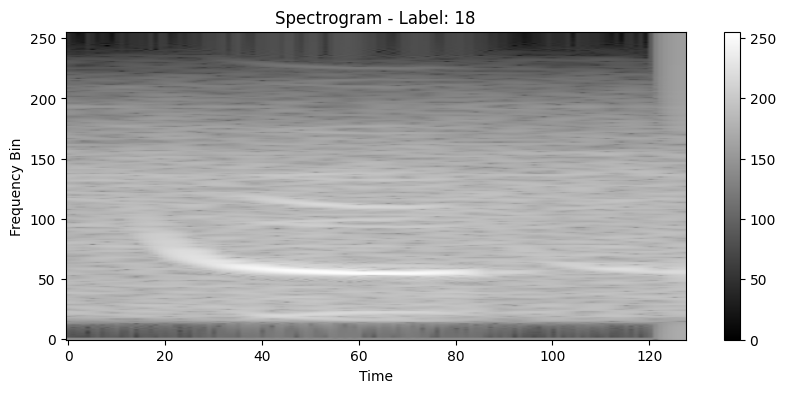

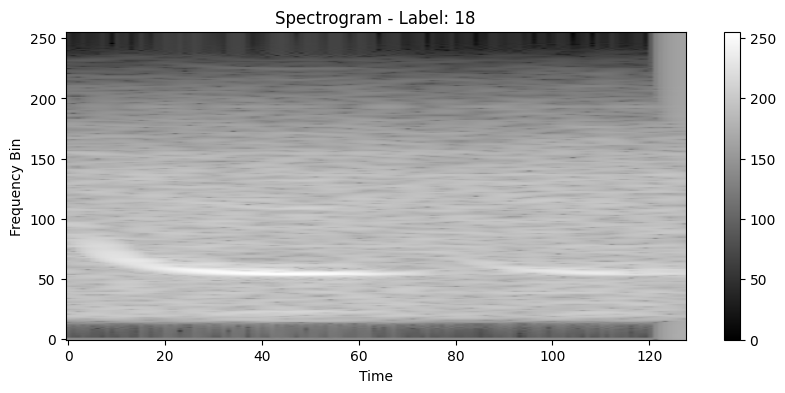

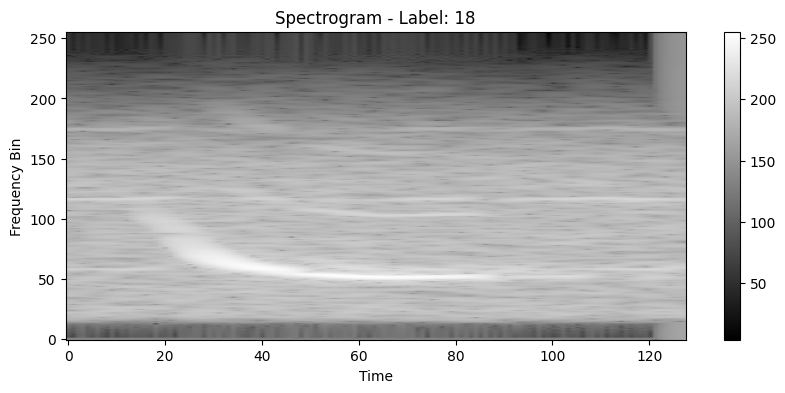

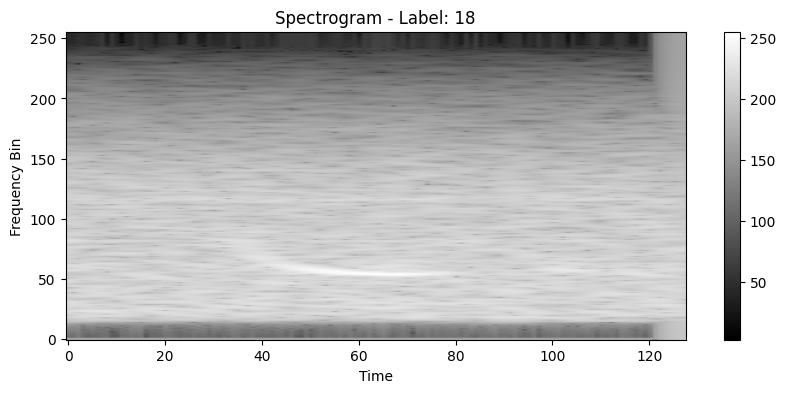

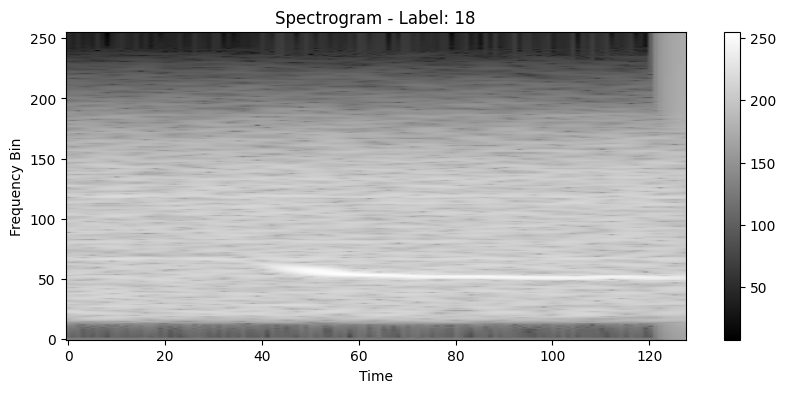

In [13]:
# Make spectrograms from db rows

def butter_bandpass(lowcut, highcut, fs, order=5):
  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  b, a = butter(order, [low, high], btype='band')
  return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
  b, a = butter_bandpass(lowcut, highcut, fs, order=order)
  y = lfilter(b, a, data)
  return y

def make_sets(data_rows):
  spec_list = []
  label_list = []
  for row in data_rows:
    #target_class = targets.index(row[1])
    target_class = row[1]
    call = row[4].astype(np.float32, order='C') / 32768.0

    # Bandpass to filter low and high frequencies
    data_bp = butter_bandpass_filter(call, 1500, 12000, 44100, 5)

    # Normalize
    data_bp -= np.mean(data_bp)
    data_bp /= np.std(data_bp)

    # Calculate spectrogram with FFT
    stft = np.abs(librosa.stft(data_bp, n_fft=512, hop_length=32))
    stft = 10 * np.log10(stft + 1e-10)
    stft = np.nan_to_num(stft)

    # Scale between [0,1] and reduce shape if needed
    stft = (stft - np.min(stft)) / (np.max(stft) - np.min(stft))
    stft = np.reshape(stft, (257, 138, 1))
    stft = stft[:256, -128: , :]

    stft = (stft* 255.0).clip(0, 255).astype(np.uint8)


    spec_list.append(stft)
    label_list.append(target_class)
  return spec_list, label_list

spectrograms, labels = make_sets(all_rows)

#print spectrogram as png
for i in range(5):
  plt.figure(figsize=(10, 4))
  plt.imshow(spectrograms[i][:,:,0], aspect='auto', origin='lower', cmap='gray')
  #plt.colorbar(format='%+2.0f dB')
  plt.colorbar()
  plt.title(f'Spectrogram - Label: {labels[i]}')
  plt.xlabel('Time')
  plt.ylabel('Frequency Bin')
  plt.show()

In [ ]:
def test_train_split(spectrograms, labels, batchsize, train_split=0.7, val_split=0.2, test_split=0.1):

  dataset = tf.data.Dataset.from_tensor_slices((spectrograms, labels))
  dataset = dataset.shuffle(buffer_size=2, seed=42)

  train_size = int(train_split * len(spectrograms))
  val_size = int(val_split * len(spectrograms))

  train_dataset = dataset.take(train_size)
  val_dataset = dataset.skip(train_size).take(val_size)
  test_dataset = dataset.skip(train_size).skip(val_size)

  train_dataset = train_dataset.batch(batchsize)
  val_dataset = val_dataset.batch(batchsize)
  test_dataset = test_dataset.batch(batchsize)

  return train_dataset, val_dataset, test_dataset

In [ ]:
# Simple CNN for binary classification

def generate_CNN():
  model = tf.keras.models.Sequential()
  # Note the input shape is the desired size of the image 200x200 with 3 bytes color
  # This is the first convolution
  model.add(Conv2D(16, (3,3), activation='relu', input_shape=(256, 128, 1)))
  model.add(MaxPooling2D(2, 2))
  # The second convolution
  model.add(Conv2D(32, (3,3), activation='relu'))
  model.add(MaxPooling2D(2, 2))
  # The third convolution
  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(MaxPooling2D(2, 2))
  # The fourth convolution
  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(MaxPooling2D(2, 2))
  # # The fifth convolution
  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(MaxPooling2D(2, 2))
  # Flatten the results to feed into a DNN
  model.add(Flatten())
  # 512 neuron hidden layer
  model.add(Dense(512, activation='relu'))
  # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('dandelions') and 1 for the other ('grass')
  model.add(Dense(1, activation='sigmoid'))

  model.summary()
  keras.utils.plot_model(model, "simple_CNN.png", show_shapes=True)
  return model

In [ ]:
# Generate and compile model

model = generate_CNN()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=RMSprop(lr=0.001),metrics=['accuracy'])

In [ ]:
# Create datasets
train_dataset, validation_dataset, test_dataset = test_train_split(spectrograms, labels, train_split=0.7, val_split=0.2, test_split=0.1, batchsize=32)

In [ ]:
# Train model

epochs = 150
history = model.fit(train_dataset,
      epochs=epochs,
      validation_data = validation_dataset
    )

In [ ]:
# Plot loss and accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
# Test prediction
test_loss, test_accuracy = model.evaluate(test_dataset)